<a href="https://colab.research.google.com/github/MichalJedruszczak/DeepLearning/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.3

In [42]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
import torchvision.datasets.folder as folder
from d2l import torch as d2l
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, precision_score, recall_score, f1_score

from sklearn.preprocessing import label_binarize
from scipy import interp

import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Importing and formatting the dataset.

In [4]:
# Unpack the dataset zip file
shutil.unpack_archive("/content/drive/MyDrive/ColabNotebooks/Datasets/CelebA/CelebAFiltered.zip", "/content/Datasets/")

In [5]:
identities_path = "/content/drive/MyDrive/ColabNotebooks/Datasets/CelebA/identity_CelebA.txt"

In [6]:
batch_size = 32
transform_train = torchvision.transforms.Compose([
    # Scale the image up to a square of 224 pixels in both height and width
    torchvision.transforms.Resize((224, 224)),

    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomRotation(degrees=15),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Randomly crop and resize

    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5206, 0.4372, 0.3924],
                                     [0.2699, 0.2501, 0.2458]),
    torchvision.transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random')
    ])




transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),

    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5206, 0.4372, 0.3924],
                                     [0.2699, 0.2501, 0.2458])])

In [7]:
data_dir = '/content/Datasets/'

# applying the correct transform pipelines for each dataset split

train_ds = torchvision.datasets.ImageFolder(
    os.path.join(data_dir, "train"),
    transform=transform_train)

valid_ds = torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'val'),
    transform=transform_train)

test_ds = torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'test'),
    transform=transform_test)

In [8]:
# creating the data loaders for each of the dataset splits

train_iter= torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True,
                                        drop_last=True)

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

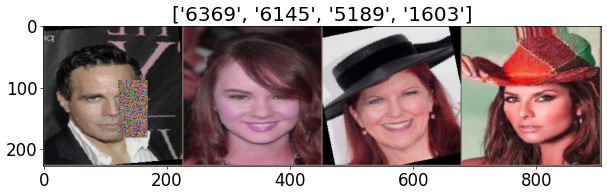

In [9]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # temporarily undo image normalisation
    mean = np.array([0.5206, 0.4372, 0.3924])
    std = np.array([0.2699, 0.2501, 0.2458])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of training images
iterator = iter(train_iter)
# visualise a batch of training images
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[train_ds.classes[x] for x in classes[:4]])

plt.rcParams.update({'font.size': 10}) #resetting font size

Above are 4 random images chosen from the training dataset.

Setting up the Resnet18 model:




In [10]:
# focal loss function

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='none'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        if self.reduction == 'mean':
            return (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()
        elif self.reduction == 'sum':
            return (self.alpha * (1 - pt) ** self.gamma * ce_loss).sum()
        else:
            return self.alpha * (1 - pt) ** self.gamma * ce_loss

In [11]:
def get_Resnet():
    num_classes = 100
    net = d2l.resnet18(num_classes, 3)
    return net

#loss = FocalLoss(reduction="none")
loss = nn.CrossEntropyLoss(reduction="none")

In [15]:
def train(net, train_iter, valid_iter, num_epochs, lr, devices, lr_period, lr_decay, patience=10, model_save_path='best_model.pth'):
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    #trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum = 0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    best_valid_acc = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2], None))

        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))

            # Save the best model
            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                epochs_without_improvement = 0
                torch.save(net.state_dict(), model_save_path)  # Save model
                print(f"Saving model with validation accuracy: {valid_acc:.4f}")
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping triggered after {epoch + 1} epochs.")
                    break

        scheduler.step()

    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 1.155, train acc 0.758, valid acc 0.448
209.3 examples/sec on [device(type='cuda', index=0)]


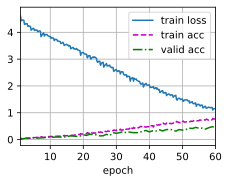

In [16]:
devices, num_epochs, lr = d2l.try_all_gpus(), 60, 2e-4
lr_period, lr_decay, net = 4, 0.9, get_Resnet()
net(next(iter(train_iter))[0])
train(net, train_iter, valid_iter, num_epochs, lr, devices, lr_period,
      lr_decay)

In [17]:
i = 0
sorted_ids = []
df = pd.DataFrame()
preds, filenames = [], []

for X, _ in test_iter:
    filenames.extend([os.path.basename(file_path) for file_path, _ in test_iter.dataset.samples[i:i+batch_size]]) #collect filenames
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
    i += batch_size

sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds, 'filename': filenames}) #add filename column
df['label'] = df['label'].apply(lambda x: valid_ds.classes[x])
df.to_csv('/content/drive/My Drive/submission.csv', index=False)

In [18]:
# Load the submission file
submission_df = pd.read_csv('/content/drive/My Drive/submission.csv')

# Load the identities file
identities_df = pd.read_csv(identities_path, sep=" ", header=None, names=["filename", "identity"])

# Merge the two dataframes based on the filename
merged_df = pd.merge(submission_df, identities_df, left_on='filename', right_on='filename', how='left')

if merged_df['identity'].isnull().any():
    # drop rows with NaN values
    merged_df = merged_df.dropna(subset=['identity'])
    print("Warning: Rows with NaN values in 'identity' column were dropped.")

correct_predictions_df = merged_df[merged_df['label'] == merged_df['identity']]
# Display the DataFrame with correct predictions
print(merged_df)

# Calculate testing accuracy
correct_predictions = (merged_df['label'] == merged_df['identity']).sum()
total_predictions = len(merged_df)
testing_accuracy = correct_predictions / total_predictions

print(f"Testing accuracy: {testing_accuracy:.4f} ({correct_predictions}/{total_predictions})")

      id  label    filename  identity
0      1  10144  000057.jpg     10144
1     10   3227  014855.jpg     10144
2    100   5578  082634.jpg     10144
3    101   1175  001977.jpg      1175
4    102   4310  046460.jpg      1175
..   ...    ...         ...       ...
299   95   3055  034934.jpg      9341
300   96   2079  099904.jpg      9341
301   97   1946  060277.jpg      9840
302   98   9290  124632.jpg      9840
303   99   9840  134362.jpg      9840

[304 rows x 4 columns]
Testing accuracy: 0.4046 (123/304)


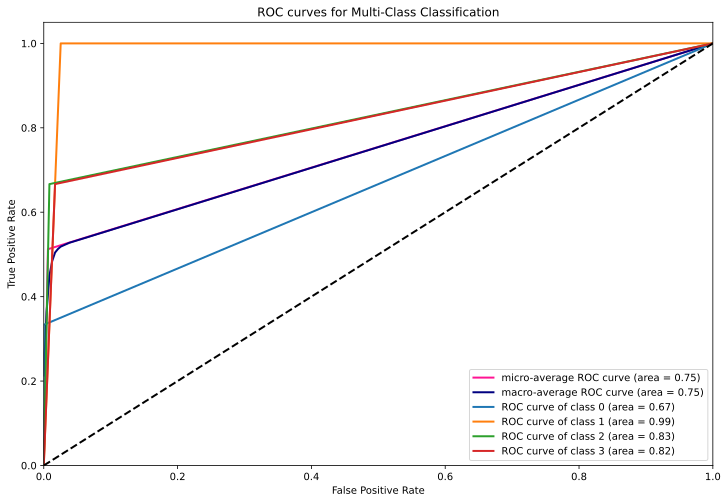

In [19]:

# Convert labels to numerical values if they are not already
label_mapping = {label: i for i, label in enumerate(merged_df['label'].unique())}
y_true = merged_df['identity'].map(label_mapping)
y_pred = merged_df['label'].map(label_mapping)

# Check for NaN values in y_true and y_pred after mapping
if y_true.isnull().any() or y_pred.isnull().any():
    # Handle NaN values, drop corresponding rows from merged_df and update y_true, y_pred
    nan_indices = y_true[y_true.isnull()].index.union(y_pred[y_pred.isnull()].index)
    merged_df = merged_df.drop(index=nan_indices)

    # Update y_true and y_pred after dropping rows
    y_true = merged_df['identity'].map(label_mapping)
    y_pred = merged_df['label'].map(label_mapping)

    print("Warning: Rows with NaN values in 'y_true' or 'y_pred' were dropped.")

# One-vs-Rest ROC curve calculation
n_classes = len(label_mapping)
fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = np.zeros((len(y_true), n_classes))

for i in range(n_classes):
    # Binary classification for class i vs. all other classes
    binary_y_true = (y_true == i).astype(int)

    # Use predicted labels as scores
    y_score[:, i] = (y_pred == i).astype(int)

    fpr[i], tpr[i], _ = roc_curve(binary_y_true, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Compute micro-average ROC curve and ROC area
y_true_onehot = np.zeros((len(y_true), n_classes))
y_pred_onehot = np.zeros((len(y_pred), n_classes))
for i, val in enumerate(y_true):
    y_true_onehot[i, val] = 1
for i, val in enumerate(y_pred):
    y_pred_onehot[i, val] = 1

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='deeppink',
         lw=lw, label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
plt.plot(fpr["macro"], tpr["macro"], color='navy',
         lw=lw, label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]))
for i in range(0,4):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert labels to numerical values
label_mapping = {label: i for i, label in enumerate(merged_df['label'].unique())}
y_true = merged_df['identity'].map(label_mapping)
y_pred = merged_df['label'].map(label_mapping)

# Check for NaN values and handle them as before
if y_true.isnull().any() or y_pred.isnull().any():
    nan_indices = y_true[y_true.isnull()].index.union(y_pred[y_pred.isnull()].index)
    merged_df = merged_df.drop(index=nan_indices)
    y_true = merged_df['identity'].map(label_mapping)
    y_pred = merged_df['label'].map(label_mapping)
    print("Warning: Rows with NaN values in 'y_true' or 'y_pred' were dropped.")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

A confusion matrix is impractical for this problem.

In [20]:

# Calculate precision and recall
precision = precision_score(merged_df['identity'], merged_df['label'], average='weighted', zero_division=0)
recall = recall_score(merged_df['identity'], merged_df['label'], average='weighted', zero_division=0)

# Calculate F1 score
f1 = f1_score(merged_df['identity'], merged_df['label'], average='weighted', zero_division=0)


print(f"Testing accuracy: {testing_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Testing accuracy: 0.4046
Precision: 0.5766
Recall: 0.5125
F1 Score: 0.4963


In [21]:

# Save the trained model to Google Drive

'''
model_save_path = '/content/drive/MyDrive/resnet18_celeba_model_adam_cel.pth'
torch.save(net.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

'''

'\nmodel_save_path = \'/content/drive/MyDrive/resnet18_celeba_model_adam_cel.pth\'\ntorch.save(net.state_dict(), model_save_path)\nprint(f"Model saved to: {model_save_path}")\n\n'

VGG Section

In [22]:
# MIT License: Copyright (c) 2018 Ben Trevett.

class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [23]:
vgg19_layers = get_vgg_layers(vgg19_config, batch_norm=False)
#print(vgg19_layers)

num_classes = 100


model = torchvision.models.vgg19_bn(pretrained=True)
pretrained_model = torchvision.models.vgg19_bn(pretrained=True)

IN_FEATURES = pretrained_model.classifier[-1].in_features

model.classifier[-1] = nn.Linear(IN_FEATURES, num_classes)

final_fc = nn.Linear(IN_FEATURES, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:02<00:00, 214MB/s]


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(reduction="none")

model = model.to(device)
criterion = criterion.to(device)

FOUND_LR = 5e-4

params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = torch.optim.Adam(params, lr=FOUND_LR)
#optimizer = torch.optim.SGD(params, lr=FOUND_LR, momentum = 0.9)

In [25]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [26]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        #y_pred, _ = model(x)
        y_pred = model(x)

        loss = criterion(y_pred, y)

        # Calculate the mean of the loss to get a scalar value
        loss = loss.mean() # This line is added

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            #y_pred, _ = model(x)
            y_pred = model(x)

            loss = criterion(y_pred, y)

            # Calculate the mean of the loss to get a scalar value
            loss = loss.mean()  # Calculate the mean of the loss tensor

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            #y_pred, _ = model(x)
            y_pred = model(x)

            y_prob = torch.nn.functional.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [29]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [30]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iter, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 32s
	Train Loss: 1.088 | Train Acc: 2.92%
	 Val. Loss: 0.874 |  Val. Acc: 11.11%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 32s
	Train Loss: 0.784 | Train Acc: 15.42%
	 Val. Loss: 0.592 |  Val. Acc: 32.29%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 32s
	Train Loss: 0.515 | Train Acc: 34.42%
	 Val. Loss: 0.427 |  Val. Acc: 47.92%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 32s
	Train Loss: 0.350 | Train Acc: 49.71%
	 Val. Loss: 0.385 |  Val. Acc: 52.43%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 32s
	Train Loss: 0.218 | Train Acc: 64.92%
	 Val. Loss: 0.350 |  Val. Acc: 55.90%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 32s
	Train Loss: 0.159 | Train Acc: 73.04%
	 Val. Loss: 0.316 |  Val. Acc: 61.46%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 32s
	Train Loss: 0.105 | Train Acc: 80.50%
	 Val. Loss: 0.282 |  Val. Acc: 63.54%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 32s
	Train Loss: 0.080 | Train Acc: 84.96%
	 Val. Loss: 0.248 |  Val. Acc: 65.97%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 31s
	Train Loss: 0.065 | Train Acc: 87.54%
	 Val. Loss: 0.255 |  Val. Acc: 68.75%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 31s
	Train Loss: 0.051 | Train Acc: 90.21%
	 Val. Loss: 0.258 |  Val. Acc: 67.36%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 31s
	Train Loss: 0.039 | Train Acc: 91.50%
	 Val. Loss: 0.251 |  Val. Acc: 69.10%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 31s
	Train Loss: 0.032 | Train Acc: 93.08%
	 Val. Loss: 0.250 |  Val. Acc: 69.44%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 31s
	Train Loss: 0.039 | Train Acc: 92.29%
	 Val. Loss: 0.254 |  Val. Acc: 68.75%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 32s
	Train Loss: 0.031 | Train Acc: 92.71%
	 Val. Loss: 0.218 |  Val. Acc: 70.83%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 32s
	Train Loss: 0.028 | Train Acc: 94.71%
	 Val. Loss: 0.216 |  Val. Acc: 70.83%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 31s
	Train Loss: 0.023 | Train Acc: 95.08%
	 Val. Loss: 0.225 |  Val. Acc: 72.57%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 31s
	Train Loss: 0.025 | Train Acc: 94.62%
	 Val. Loss: 0.232 |  Val. Acc: 71.53%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 31s
	Train Loss: 0.022 | Train Acc: 95.08%
	 Val. Loss: 0.250 |  Val. Acc: 73.26%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 31s
	Train Loss: 0.024 | Train Acc: 95.04%
	 Val. Loss: 0.229 |  Val. Acc: 69.79%


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 31s
	Train Loss: 0.019 | Train Acc: 96.04%
	 Val. Loss: 0.283 |  Val. Acc: 65.28%


In [31]:
model.load_state_dict(torch.load('best-model.pt'))

<ipython-input-31-f8ea9cd1c708>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best-model.pt'))


<All keys matched successfully>

In [32]:
images, labels, probs = get_predictions(model, test_iter)

  0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
test_dir = '/content/Datasets/test'

# Get a list of all subfolders (class names)
class_names = [f for f in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, f))]

# Create a list to store the data for the CSV
data = []

# Iterate through each subfolder
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    # Iterate through each image file in the subfolder
    for image_file in os.listdir(class_dir):
        # Create a row for the CSV with image file name and class name
        data.append([image_file, class_name])

# Create a Pandas DataFrame from the data
df = pd.DataFrame(data, columns=['id', 'class'])

# Save the DataFrame to a CSV file
df.to_csv('test_ground_truth.csv', index=False)

In [34]:
predicted_labels = np.argmax(probs, axis=1)

In [35]:
test = pd.read_csv('/content/test_ground_truth.csv')
y_test_original = np.array(test['class'])

In [36]:
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_test_original, classes=np.unique(y_test_original))
n_classes = y_test.shape[1]  # Get the number of classes from y_test

In [37]:


#Convert to numerical labels
from sklearn.preprocessing import LabelEncoder


# Before label encoding, extract class names and save
original_class_names = train_ds.classes  # Assuming train_ds is your ImageFolder dataset

# Create a DataFrame with a single column for class names
class_names_df = pd.DataFrame({'class_names': original_class_names})

# Save to CSV
class_names_df.to_csv('original_class_names.csv', index=False)



label_encoder = LabelEncoder()
y_test_original = label_encoder.fit_transform(y_test_original)


#Check dimensions of labels and original labels and adjust to match
print(f"Shape of labels: {labels.shape}")
print(f"Shape of y_test_original: {y_test_original.shape}")

#Adjust predicted_labels to match the size of labels
predicted_labels_adjusted = predicted_labels[:labels.shape[0]]
y_test_original_adjusted = y_test_original[:labels.shape[0]]

# Binarize the labels for ROC curve calculation
y_test = label_binarize(y_test_original_adjusted, classes=np.unique(y_test_original_adjusted))
n_classes = y_test.shape[1]  # Get the number of classes from y_test



Shape of labels: torch.Size([304])
Shape of y_test_original: (304,)


In [38]:
images, labels, probs = get_predictions(model, test_iter)
probs = probs.numpy()

  0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
test_df = pd.read_csv('test_ground_truth.csv')

# Get the image IDs from the DataFrame
image_ids = test_df['id'].values

# Get the predicted labels
predicted_labels = predicted_labels_adjusted

# Create a dictionary to store the data for the CSV
data = {'id': image_ids, 'class': predicted_labels}

# Create a Pandas DataFrame from the data
predictions_df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
predictions_df.to_csv('predicted_outputs.csv', index=False)


In [40]:
# Retrieve original class names
original_class_names = label_encoder.classes_

# Map predicted indices to class names using a dictionary
predicted_class_names = [original_class_names[i] for i in predicted_labels_adjusted.cpu().numpy() if i in range(len(original_class_names))]

# Update predictions DataFrame
predictions_df['class'] = predicted_class_names

# Save updated predictions
predictions_df.to_csv('predicted_outputs_with_names.csv', index=False)



<ipython-input-43-be7d5ee22115>:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


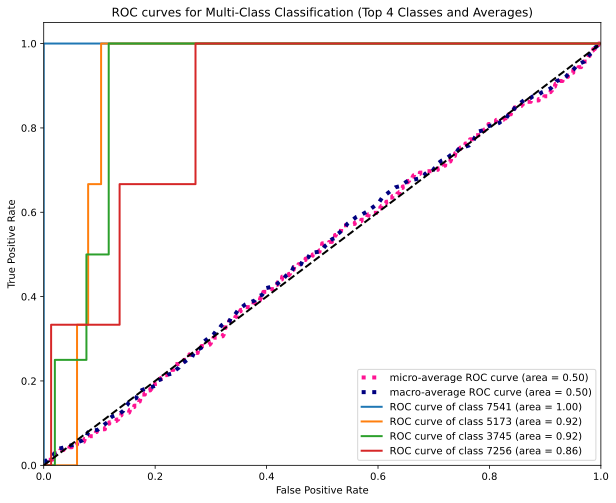

In [43]:


# Ensure y_test_original_adjusted and predicted_labels_adjusted have the same length
min_len = min(len(y_test_original_adjusted), len(predicted_labels_adjusted))
y_test_original_adjusted = y_test_original_adjusted[:min_len]
predicted_labels_adjusted = predicted_labels_adjusted[:min_len]

# Binarize the labels
y_test_bin = label_binarize(y_test_original_adjusted, classes=np.unique(y_test_original_adjusted))
n_classes = y_test_bin.shape[1]

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Get the top 4 classes based on AUC
top_4_classes_idx = sorted(range(n_classes), key=lambda i: roc_auc[i], reverse=True)[:4]
top_4_classes = [original_class_names[i] for i in top_4_classes_idx]  # Use original_class_names here

# Plot all ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i, class_name in zip(top_4_classes_idx, top_4_classes):  # Use class_name for label
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))  # Use class_name here

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for Multi-Class Classification (Top 4 Classes and Averages)')
plt.legend(loc="lower right")
plt.show()

In [44]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

images, labels, probs = get_predictions(model, test_iter)
predicted_labels = probs.argmax(dim=1)  # Get predicted labels from probabilities

accuracy = accuracy_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())
precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 0.7829
Precision: 0.8248
Recall: 0.7829
F1 Score: 0.7750


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
# MIT License: Copyright (c) 2018 Ben Trevett.
def plot_filtered_images(images, filters, n_filters=None, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = torch.nn.functional.conv2d(images, filters)

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

    fig.subplots_adjust(hspace=-0.7)

In [46]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

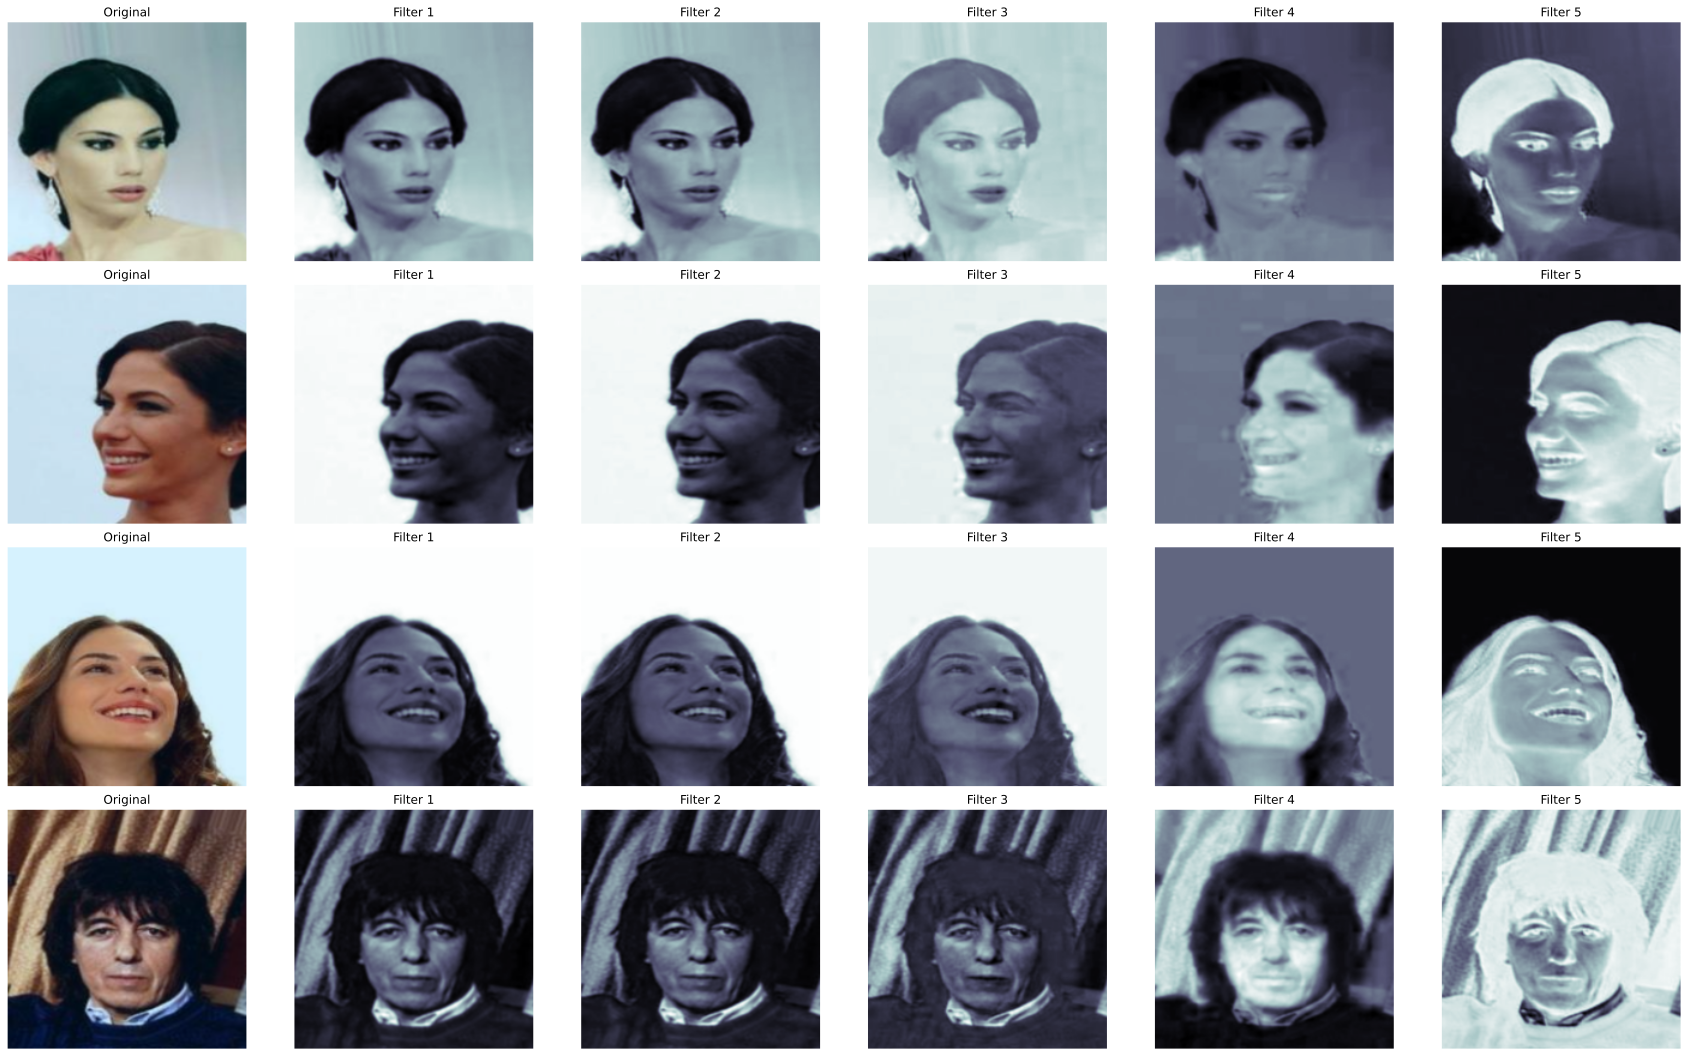

In [47]:
N_IMAGES = 4
N_FILTERS = 5

images = [image for image, label in [test_ds[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)